# Train Notebook is based on Keras 3.0 with TF


- tensorflow-2.15.0
- keras_cv-0.8.1
- keras-3.0.4


In [ ]:
%cd ..

Скачиваем датасеты

In [ ]:
# если вы их уже скачали то пропустите эту ячейку
! git clone -b datasets https://github.com/maxsemakov/test_kvant.git

In [3]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # you can also use jax, tensorflow or torch


import keras_cv
import keras
#from tensorflow import keras
from keras import ops
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

import sys
import platform


In [4]:
print("ОС: ", platform.system())
print("Архитектура: ", platform.machine())
print("Версия Python: ", sys.version_info)

ОС:  Darwin
Архитектура:  arm64
Версия Python:  sys.version_info(major=3, minor=11, micro=6, releaselevel='final', serial=0)


In [5]:
print(tf.__version__)
try:
    print(keras.__version__)
except:
    print('Tf.Keras')
print(keras_cv.__version__)

2.16.1
3.2.1
0.8.2


In [6]:
# Определите и инициализируйте TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('TPU active')
except ValueError:
    tpu = None
    print('TPU non active')

# Создайте стратегию распределения
if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    gpus = tf.config.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
            
    if len(gpus) >= 2:
        strategy = tf.distribute.MirroredStrategy()
    else:
        strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU

print("Number of replicas:", strategy.num_replicas_in_sync)
print(tf.config.list_physical_devices())

TPU non active
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of replicas: 1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:

print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
tf.test.gpu_device_name()

2024-04-17 09:59:51.203949: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-17 09:59:51.203972: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-04-17 09:59:51.203977: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-04-17 09:59:51.203996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-17 09:59:51.204008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


'/device:GPU:0'

# Config

In [9]:
class Config:
    
    DEV = "TPU" if tpu else "GPU"
    if tpu:
        CACHE=True
        CACHE_DIR=""
    else:
        CACHE=False
        CACHE_DIR=""
        
    VERSION = 1
    DF_VERSION = 1
    MIX = 0 # USE MIXED PRECISION
    SEED = 42
    IMAGE_SIZE = (128, 256) 
    BATCH_SIZE = 256* strategy.num_replicas_in_sync
    EPOCHS = 25
    EARLY_STOPPING = 6 # Количество эпох через которое надо остановить обучение если нет улучшения результата
    LR_MODE = 'cos' #'exp' , 'step' - режим измененмя скорости обучения
    
    CLASS_NAMES = ['BrassMono-BoldItalic', 
                   'GhastlyPanicCyr', 
                   'ambidexter_regular',
                   'GaneshaType-Regular', 
                   'AlumniSansCollegiateOne-Italic',
                   'AlumniSansCollegiateOne-Regular', 
                   'BrassMono-Italic',
                   'better-vcr-5.2', 
                   'ArefRuqaaInk-Bold', 
                   'Aguante-Regular',
                   'BrassMono-Bold', 
                   'ArefRuqaaInk-Regular', 
                   'Realest-Extended',
                   'BrassMono-Regular', 
                   'TanaUncialSP']
    LABEL2NAME = dict(enumerate(CLASS_NAMES))
    NAME2LABEL = {v:k for k, v in LABEL2NAME.items()}
    NUM_CLASSES = len(CLASS_NAMES)
    AUTOTUNE = tf.data.AUTOTUNE
    PRESET = 'efficientnetv2_b2_imagenet'   #'efficientnetv2_b2_imagenet','efficientnetv2_s_imagenet', 'efficientnetv2_b0_imagenet_classifier'
                                    #"yolo_v8_l_backbone_coco", "yolo_v8_m_backbone_coco"# Name of pretrained MODEL
                                    #"densenet121_imagenet"
                                    #"csp_darknet_l", "csp_darknet_l_imagenet"
                                    #"vitdet_large_sa1b"
    fold = 2 # Which fold to set as validation data
    VERBOSE = 1  # Verbosity
    LR_START, LR_MAX, LR_MIN = 1e-5, 5e-5 , 1e-6
    DATASET_DIR = 'dataset'

CFG = Config()
keras.utils.set_random_seed(seed=CFG.SEED)


In [10]:
# USE MIXED PRECISION

if CFG.MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Using full precision


# Read dataset

In [11]:
root_dir = CFG.DATASET_DIR
data = []

# Проходим по всем папкам в исходном каталоге
for font_name in os.listdir(root_dir):
    font_dir = os.path.join(root_dir, font_name)
    
    # Проверяем, является ли элемент директорией
    if os.path.isdir(font_dir):
        # Проходим по всем папкам внутри папки шрифта
        for image_type in os.listdir(font_dir):
            image_dir = os.path.join(font_dir, image_type)
            
            # Проверяем, является ли элемент директорией
            if os.path.isdir(image_dir):
                # Проходим по всем файлам внутри папки типа изображения
                for file in os.listdir(image_dir):
                    # Проверяем, является ли файл изображением .png
                    if file.endswith('.png'):
                        file_path = os.path.join(image_dir, file)
                        
                        # Добавляем информацию в список
                        data.append([font_name, image_type, file_path])

# Создаем DataFrame
df = pd.DataFrame(data, columns=['font_name', 'image_type', 'path'])


In [12]:
df.head()

,font_name,image_type,path
0,TanaUncialSP,glyphs,dataset/TanaUncialSP/glyphs/80_12_12.png
1,TanaUncialSP,glyphs,dataset/TanaUncialSP/glyphs/100_195.png
2,TanaUncialSP,glyphs,dataset/TanaUncialSP/glyphs/80_12_155.png
3,TanaUncialSP,glyphs,dataset/TanaUncialSP/glyphs/80_12_141.png
4,TanaUncialSP,glyphs,dataset/TanaUncialSP/glyphs/100_181.png


In [34]:
df['font_name'].unique()

array(['TanaUncialSP', 'ArefRuqaaInk-Regular', 'GaneshaType-Regular',
       'BrassMono-Italic', 'AlumniSansCollegiateOne-Italic',
       'Realest-Extended', 'GhastlyPanicCyr', 'BrassMono-Bold',
       'BrassMono-Regular', 'AlumniSansCollegiateOne-Regular',
       'better-vcr-5.2', 'ArefRuqaaInk-Bold', 'ambidexter_regular',
       'Aguante-Regular', 'BrassMono-BoldItalic'], dtype=object)

In [14]:
CFG.NAME2LABEL, CFG.LABEL2NAME, CFG.NUM_CLASSES

({'BrassMono-BoldItalic': 0,
  'GhastlyPanicCyr': 1,
  'ambidexter_regular': 2,
  'GaneshaType-Regular': 3,
  'AlumniSansCollegiateOne-Italic': 4,
  'AlumniSansCollegiateOne-Regular': 5,
  'BrassMono-Italic': 6,
  'better-vcr-5.2': 7,
  'ArefRuqaaInk-Bold': 8,
  'Aguante-Regular': 9,
  'BrassMono-Bold': 10,
  'ArefRuqaaInk-Regular': 11,
  'Realest-Extended': 12,
  'BrassMono-Regular': 13,
  'TanaUncialSP': 14},
 {0: 'BrassMono-BoldItalic',
  1: 'GhastlyPanicCyr',
  2: 'ambidexter_regular',
  3: 'GaneshaType-Regular',
  4: 'AlumniSansCollegiateOne-Italic',
  5: 'AlumniSansCollegiateOne-Regular',
  6: 'BrassMono-Italic',
  7: 'better-vcr-5.2',
  8: 'ArefRuqaaInk-Bold',
  9: 'Aguante-Regular',
  10: 'BrassMono-Bold',
  11: 'ArefRuqaaInk-Regular',
  12: 'Realest-Extended',
  13: 'BrassMono-Regular',
  14: 'TanaUncialSP'},
 15)

In [15]:
df['class_label'] = df.font_name.map(CFG.NAME2LABEL)


In [16]:
class InversionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(InversionLayer, self).__init__(**kwargs)

    def call(self, data, training=None):
        if training:
            data["images"] = 1.0 - data["images"]
        return data
    

def build_augmenter(dim=CFG.IMAGE_SIZE):
    augmenters = [

        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
        keras_cv.layers.RandomCutout(height_factor=(0.2, 0.5), width_factor=(0.3, 0.6)), 
        keras_cv.layers.RandomShear(
                                        x_factor=0.2,
                                        y_factor=0.4,
                                        interpolation="bilinear",
                                        fill_mode="reflect",
                                        fill_value=0.3,
                                        bounding_box_format=None,
                                        seed=CFG.SEED
                                    ),
        InversionLayer() # добавляем слой инверсии
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            ran = tf.random.uniform([])
            #tf.print(ran)
            if ran < 0.18:
                #tf.print(augmenter)
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment


def build_decoder(with_labels=True, 
                  target_size=CFG.IMAGE_SIZE, 
                  dtype=32, 
                ):
    
    def decode_img(path):
        file_bytes = tf.io.read_file(path)
        image = tf.io.decode_png(file_bytes, channels=1, dtype=tf.uint8)
        image = tf.image.resize(image, CFG.IMAGE_SIZE, method="bilinear")
        image = tf.cast(image, tf.float32) / 255.0
        
        # Mono channel to 3 channels to use "ImageNet" weights
        image = tf.tile(image, [1, 1, 3])
        
        return image


        


    def decode_label(label):
        label = tf.one_hot(label, CFG.NUM_CLASSES)
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [CFG.NUM_CLASSES])
        return label
    
    def decode_with_labels(path, label=None):
        img = decode_img(path)
        label = decode_label(label)
        return (img, label)
    
    return decode_with_labels if with_labels else decode_img


def build_dataset( 
                  paths, 
                  labels=None, 
                  batch_size=32, 
                  cache=True,
                  decode_fn=None,
                  augment_fn=None,
                  augment=False, 
                  repeat=True, 
                  shuffle=1024, 
                  cache_dir="", 
                  drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter()
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths) if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.SEED)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

# 🔪 | Data Split

In the following code snippet, the data is divided into `5` folds. Note that, the `groups` argument is used to prevent any overlap of patients between the training and validation sets, thus avoiding potential **data leakage** issues. Additionally, each split is stratified based on the `class_label`, ensuring a uniform distribution of class labels in each fold.

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.SEED)

df["fold"] = -1
df.reset_index(drop=True, inplace=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, y=df["class_label"])):
    df.loc[valid_idx, "fold"] = fold
df.groupby(["fold", "font_name"])[["path"]].count()

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/envs/p311/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


path
fold font_name                            
0    Aguante-Regular                  4719
     AlumniSansCollegiateOne-Italic   4959
     AlumniSansCollegiateOne-Regular  4958
     ArefRuqaaInk-Bold                4743
     ArefRuqaaInk-Regular             4744
...                                    ...
4    GhastlyPanicCyr                  4671
     Realest-Extended                 4715
     TanaUncialSP                     4676
     ambidexter_regular               4768
     better-vcr-5.2                   7786

[75 rows x 1 columns]

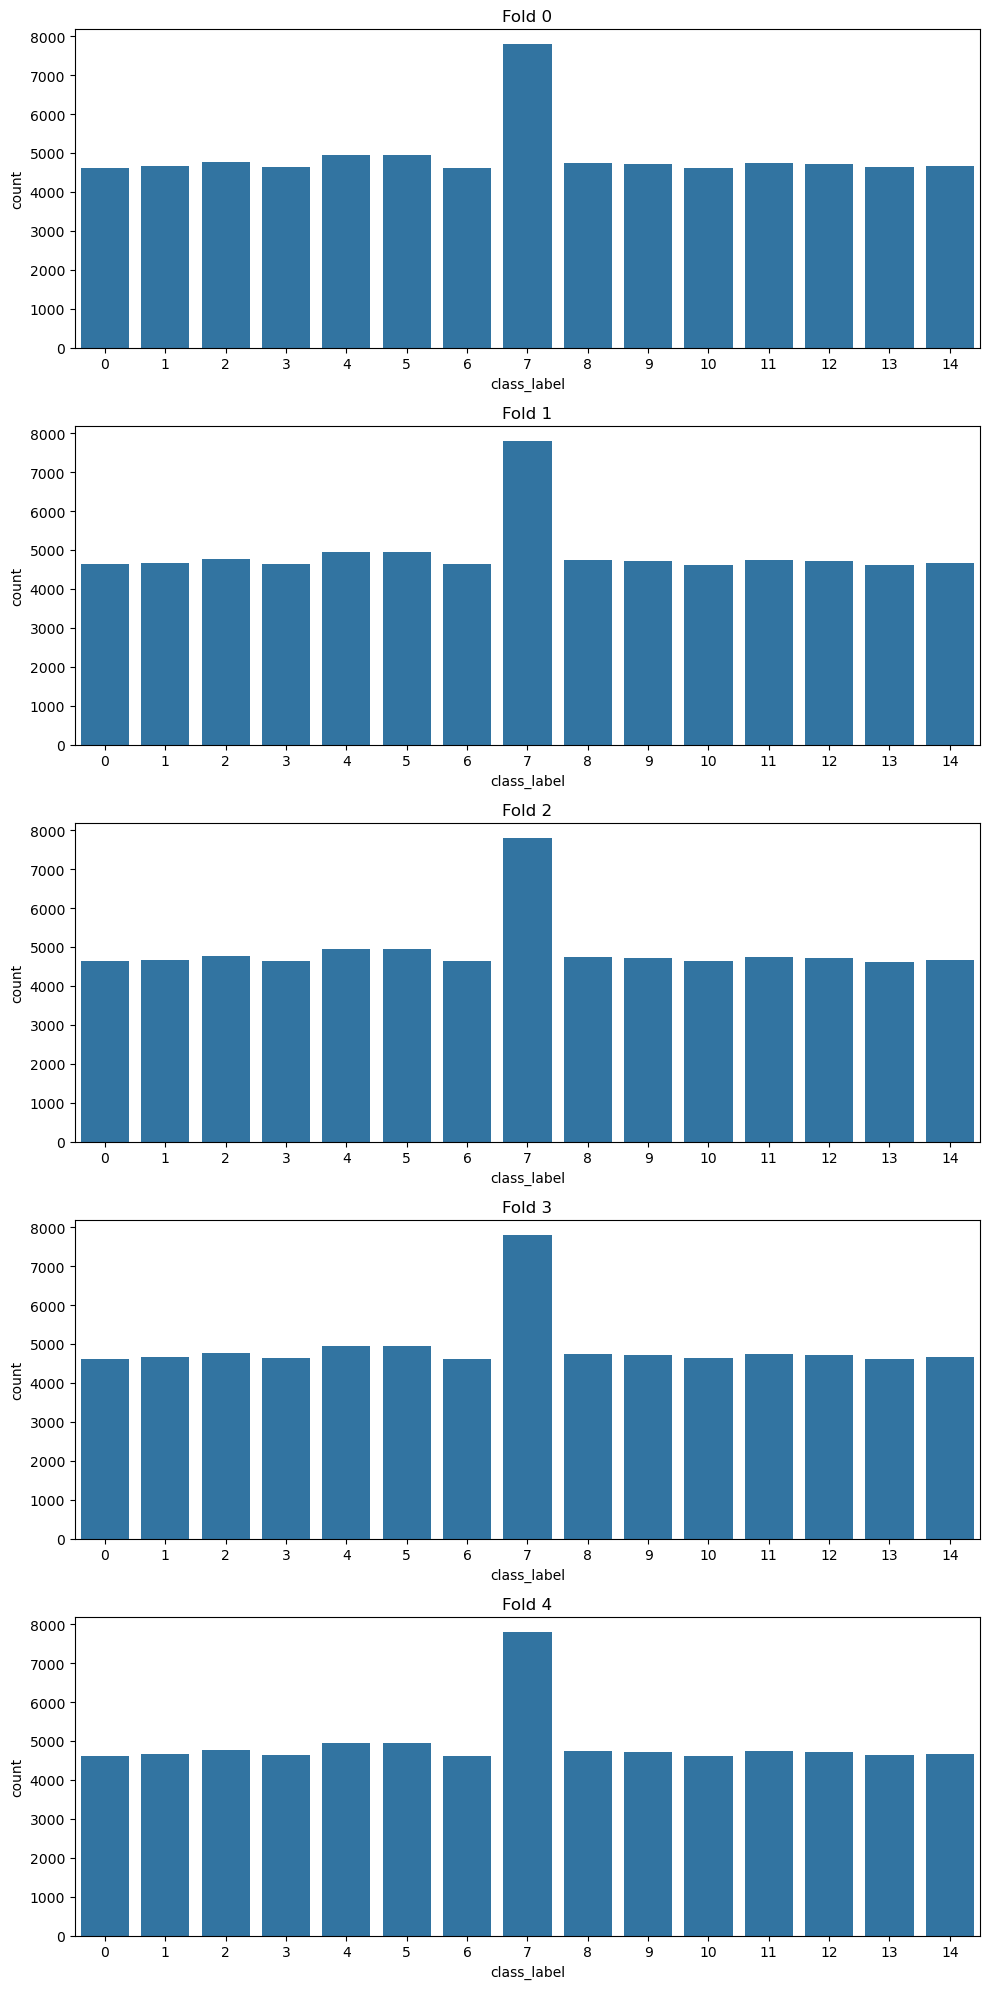

In [18]:
# Создаем фигуру и оси
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Для каждой группы строим гистограмму
for fold in range(5):
    # Выбираем подмножество данных для данной группы
    subset = df[df["fold"] == fold]
    
    # Строим гистограмму
    sns.countplot(data=subset, x="class_label", ax=axs[fold])
    
    # Устанавливаем заголовок
    axs[fold].set_title(f"Fold {fold}")
    
# Показываем график
plt.tight_layout()
plt.show()

In [19]:
df.head()

,font_name,image_type,path,class_label,fold
0,TanaUncialSP,glyphs,dataset/TanaUncialSP/glyphs/80_12_12.png,14,3
1,TanaUncialSP,glyphs,dataset/TanaUncialSP/glyphs/100_195.png,14,4
2,TanaUncialSP,glyphs,dataset/TanaUncialSP/glyphs/80_12_155.png,14,4
3,TanaUncialSP,glyphs,dataset/TanaUncialSP/glyphs/80_12_141.png,14,0
4,TanaUncialSP,glyphs,dataset/TanaUncialSP/glyphs/100_181.png,14,2


In [20]:
# Sample from  data
sample_df = df.sample(frac=0.05).reset_index(drop=True) #использую здесь только 5% dataset для тестов 
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
train_paths = train_df.path.values
train_labels = train_df.class_label.values

train_ds = build_dataset(paths=train_paths,  
                         labels=train_labels,
                         batch_size=CFG.BATCH_SIZE,
                         repeat=True, 
                         shuffle=True, 
                         augment=True, 
                         cache=False,
                         #cache_dir=CFG.CACHE_DIR
                        )

# Valid
valid_paths = valid_df.path.values
valid_labels = valid_df.class_label.values

valid_ds = build_dataset(paths=valid_paths,  
                         labels=valid_labels,
                         batch_size=CFG.BATCH_SIZE,
                         repeat=None, 
                         shuffle=None, 
                         augment=None, 
                         cache=False,
                         #cache_dir=CFG.CACHE_DIR
                        )

# Num Train: 14665 | Num Valid: 3804


2024-04-17 09:59:52.798818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-17 09:59:52.798840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
iterator = iter(train_ds)

2024-04-17 09:59:53.264828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


(256, 128, 256, 3)
Минимальное значение в матрице:  0.0
Maximal значение в матрице:  1.0


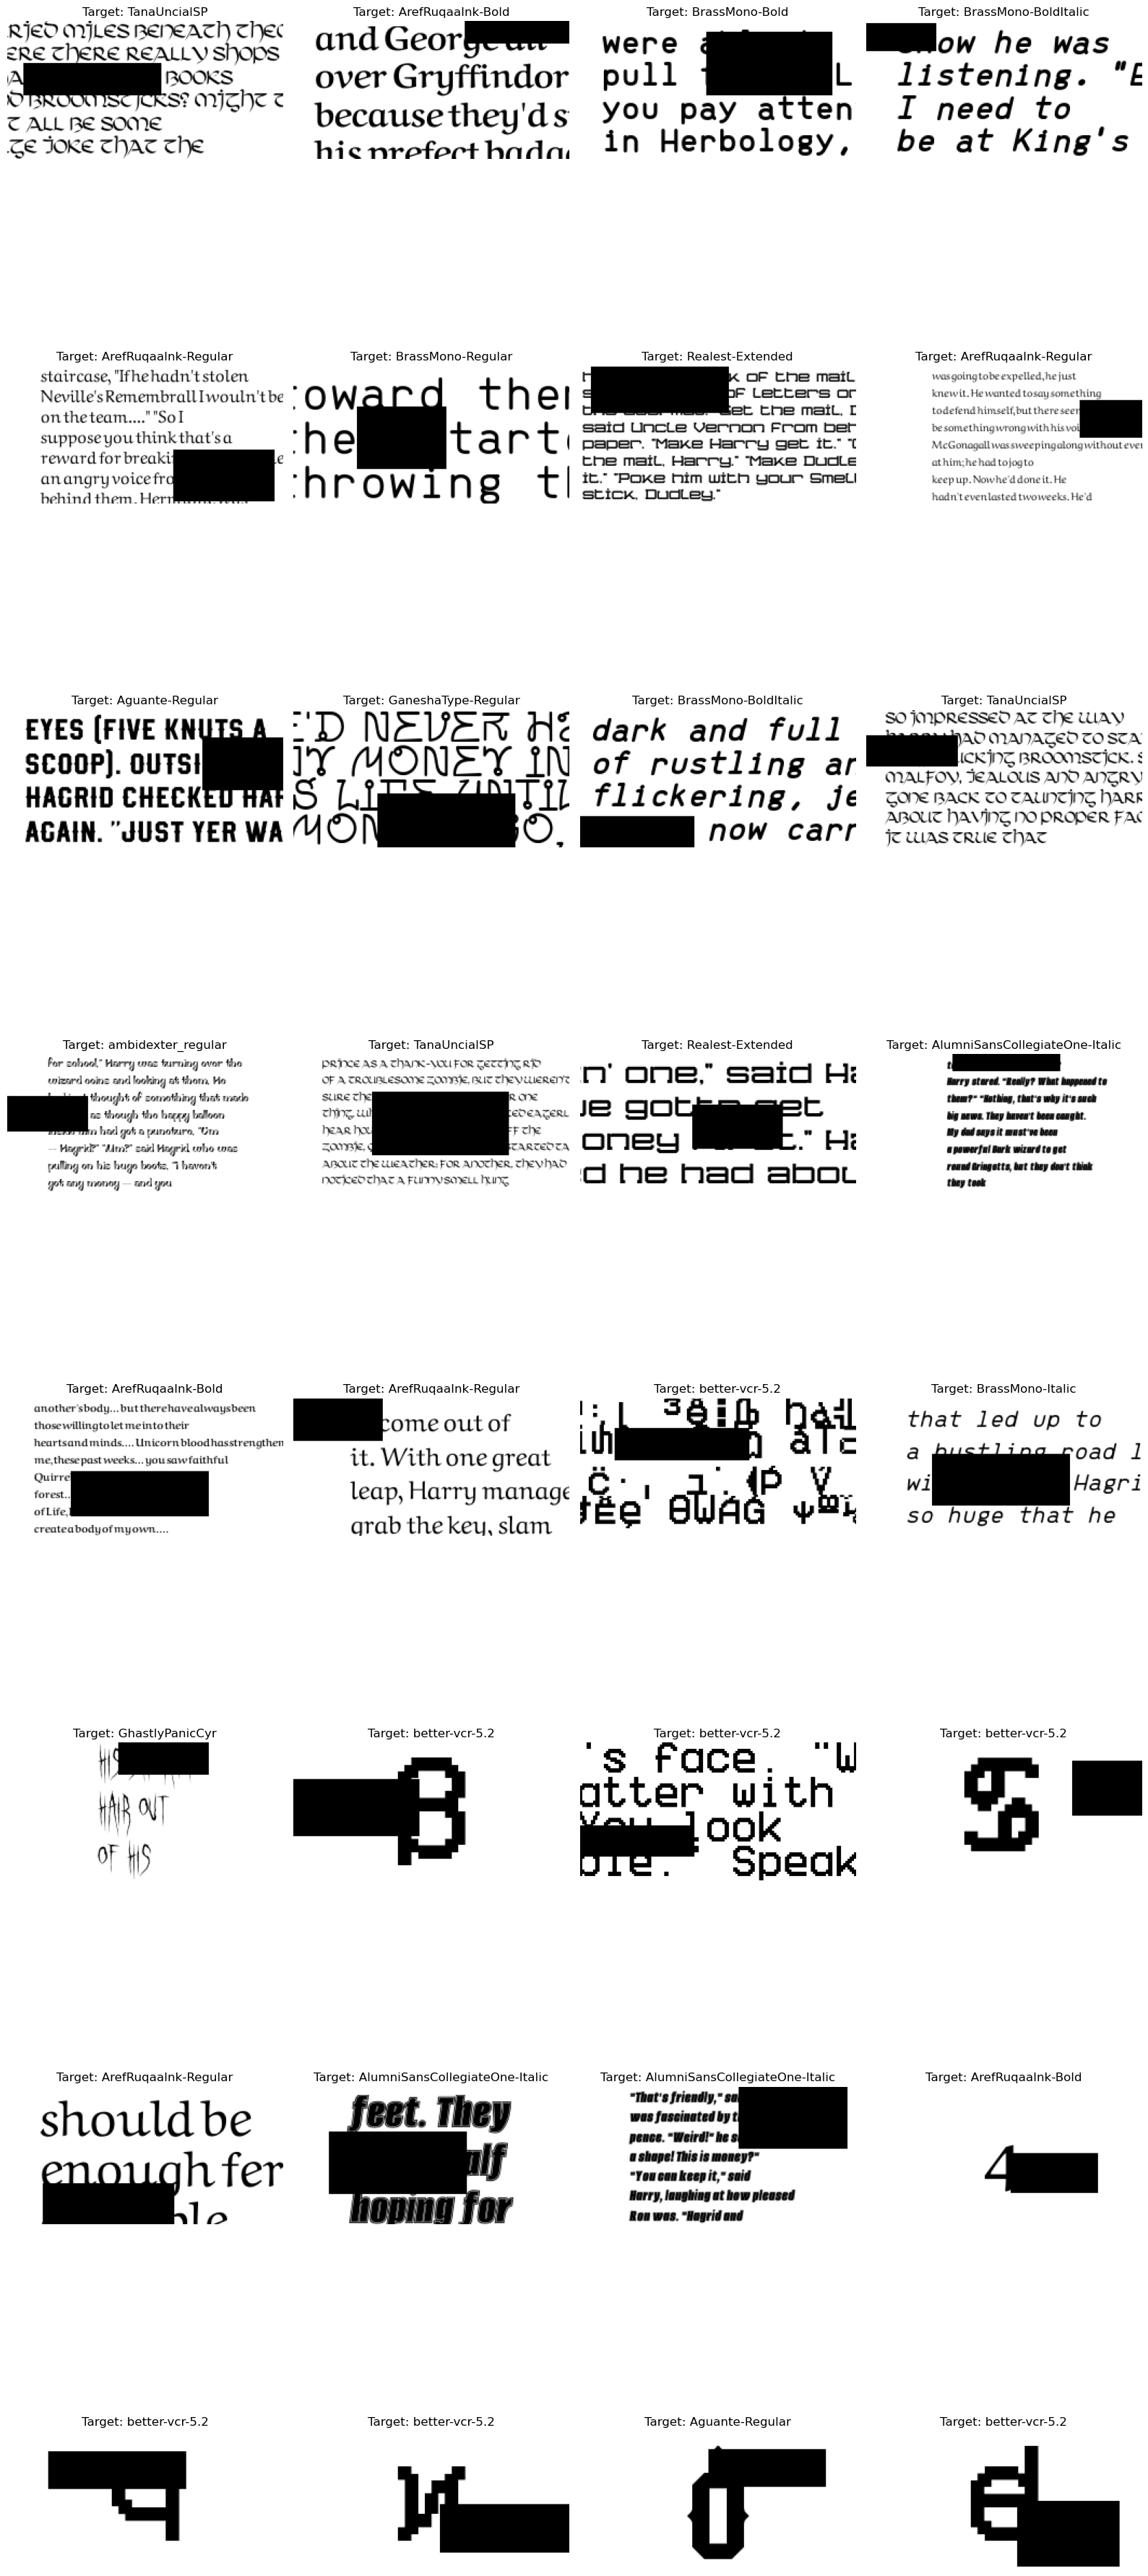

In [22]:
imgs, tars = next(iterator)
print(imgs.shape)
SIZE = imgs.shape[1:]
min_value = np.min(imgs)
max_value = np.max(imgs)
print("Минимальное значение в матрице: ", min_value)
print("Maximal значение в матрице: ", max_value)
num_imgs = 32
plt.figure(figsize=(4*4, num_imgs//4*5))
for i in range(num_imgs):
    plt.subplot(num_imgs//4, 4, i + 1)
    img = imgs[i].numpy()[...,0]  # Adjust as per your image data format
    tar = CFG.LABEL2NAME[np.argmax(tars[i].numpy())]
    plt.imshow(img, cmap='gray')
    plt.title(f"Target: {tar}")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

## 🤖 | Modeling¶

This notebook uses the EfficientNetV2 B2 from KerasCV's collection of pretrained models. To explore other models, simply modify the preset in the CFG (config). Check the KerasCV website for a list of available pretrained models.

In [24]:
def build_model():
    with strategy.scope():

            
        model = keras_cv.models.ImageClassifier.from_preset(
        
            CFG.PRESET,
            #pooling="avg", 
            #activation="softmax",
            num_classes=CFG.NUM_CLASSES  
        )

        # Compile the model  
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                        loss='categorical_crossentropy', 
                        metrics=['accuracy']
                        )
    return model
model = build_model()
# Model Sumamry
print(model.summary())

Model: "image_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficient_net_v2b2_backbone     │ (None, None, None,     │     8,769,374 │
│ (EfficientNetV2Backbone)        │ 1408)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 15)             │        21,135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,790,509 (33.53 MB)

 Trainable params: 8,708,221 (33.22 MB)

 Non-trainable params: 82,288 (321.44 KB)

None


In [25]:
filepath = 'train_1st/best_model.keras'
model.load_weights(filepath, skip_mismatch=True)

/opt/anaconda3/envs/p311/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 622 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


## Early stopping round

In [26]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=CFG.EARLY_STOPPING,
    restore_best_weights=True
)

## ⚓ | LR Schedule
A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

- lr_ramp_ep: Это количество эпох, в течение которых скорость обучения увеличивается от lr_start до lr_max. Это помогает модели медленно “разогреваться” перед тем, как перейти к более высокой скорости обучения.
- lr_sus_ep: Это количество эпох, в течение которых скорость обучения остается на уровне lr_max. Это позволяет модели “устояться” на определенной скорости обучения перед тем, как начать затухание.
- lr_decay: Это коэффициент затухания, который определяет, насколько быстро скорость обучения уменьшается после “поддержания”. Значение меньше 1 означает, что скорость обучения будет уменьшаться с каждой эпохой.
- lr_start: Это начальная скорость обучения. Это значение, с которого начинается “разогрев” скорости обучения.
- lr_max: Это максимальная скорость обучения, которую модель может достичь в процессе “разогрева”. После достижения этого значения, скорость обучения либо остается на этом уровне в течение определенного количества эпох (lr_sus_ep), либо начинает затухать.
- lr_min: Это минимальная скорость обучения, которую модель может достичь в процессе затухания. Это значение, к которому стремится скорость обучения после “разогрева” и “поддержания”.

In [27]:
import math


def get_lr_callback(batch_size=CFG.BATCH_SIZE, 
                    mode='cos', 
                    epochs=CFG.EPOCHS, 
                    plot=False, 
                    lr_start = CFG.LR_START, 
                    lr_max = CFG.LR_MAX, 
                    lr_min = CFG.LR_MIN):

    #lr_start, lr_max, lr_min = 1e-5, 6e-5 , 1e-7 #2e-6 * batch_size
    lr_ramp_ep, lr_sus_ep, lr_decay = epochs//5, 1, 0.1
    
    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

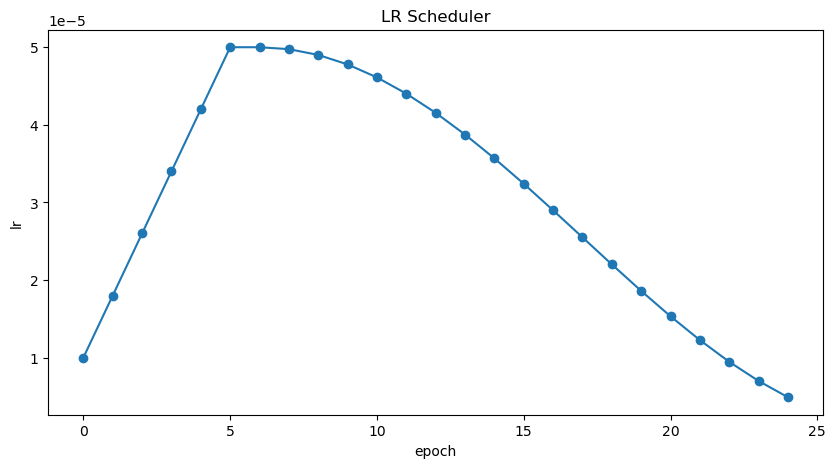

In [28]:
lr_cb = get_lr_callback(CFG.BATCH_SIZE, mode=CFG.LR_MODE, plot=True)

## 💾 | Model Checkpointing & CSV logger

In [29]:
ckpt_cb = keras.callbacks.ModelCheckpoint(f"tmp/best_model.keras",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         mode='min')

In [30]:
csv_logger = keras.callbacks.CSVLogger('tmp/training_log.csv', separator=',', append=False)

In [31]:
#with strategy.scope():
history = model.fit(
    train_ds, 
    epochs=CFG.EPOCHS,
    callbacks=[
        lr_cb, 
        ckpt_cb, 
        csv_logger,
        early_stopping
    ], 
    steps_per_epoch=len(train_df)//CFG.BATCH_SIZE,
    validation_data=valid_ds, 
    verbose=CFG.VERBOSE
)

Epoch 1/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 1383s 12s/step - accuracy: 0.4706 - loss: 2.1362 - val_accuracy: 0.5231 - val_loss: 1.7094 - learning_rate: 1.0000e-05
Epoch 2/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 498s 9s/step - accuracy: 0.6314 - loss: 1.2264 - val_accuracy: 0.8962 - val_loss: 0.3677 - learning_rate: 1.8000e-05
Epoch 3/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 483s 8s/step - accuracy: 0.7602 - loss: 0.7928 - val_accuracy: 0.9493 - val_loss: 0.1931 - learning_rate: 2.6000e-05
Epoch 4/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 458s 8s/step - accuracy: 0.8286 - loss: 0.5600 - val_accuracy: 0.9432 - val_loss: 0.1704 - learning_rate: 3.4000e-05
Epoch 5/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 493s 9s/step - accuracy: 0.8957 - loss: 0.3474 - val_accuracy: 0.9519 - val_loss: 0.1341 - learning_rate: 4.2000e-05
Epoch 6/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 526s 9s/step - accuracy: 0.9437 - loss: 0.1976 - val_accuracy: 0.9742 - val_loss: 0.0805 - learning_rate: 5.0000e-05
Epoch 7/25
57/57 ━━━━━━━━━━━━━━━━━━━━ 524s 9s/step - accuracy: 0.947

# |Results of train

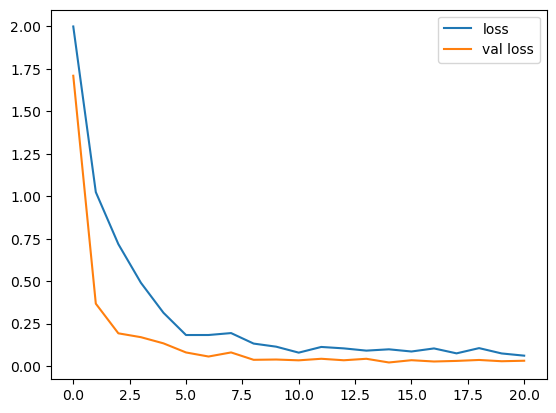

In [32]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [33]:
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc = history.history['val_accuracy'][best_epoch]

print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')

>>>> BEST Loss  : 0.021
>>>> BEST Acc   : 0.994
>>>> BEST Epoch : 14

